# Clustering Crypto

In [114]:
# Initial imports
import requests
import pandas as pd
import matplotlib.pyplot as plt
import hvplot.pandas
import plotly.express as px
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

### Fetching Cryptocurrency Data

In [115]:
# Use the following endpoint to fetch json data
#url = "https://min-api.cryptocompare.com/data/all/coinlist"

In [116]:
# Create a DataFrame 
# HINT: You will need to use the 'Data' key from the json response, then transpose the DataFrame.
#response = requests.get(url)
#response_json = response.json()
#df = response_json['Data']
#df2 = pd.DataFrame.from_dict(df).T
#df2

In [117]:
# Alternatively, use the provided csv file:
from pathlib import Path
file_path = Path("Resources/crypto_data.csv")

# Create a DataFrame
crypto_df = pd.read_csv(file_path, index_col = 0)
crypto_df.head()

,CoinName,Algorithm,IsTrading,ProofType,TotalCoinsMined,TotalCoinSupply
42,42 Coin,Scrypt,True,PoW/PoS,4.199995e+01,42
365,365Coin,X11,True,PoW/PoS,NaN,2300000000
404,404Coin,Scrypt,True,PoW/PoS,1.055185e+09,532000000
611,SixEleven,SHA-256,True,PoW,NaN,611000
808,808,SHA-256,True,PoW/PoS,0.000000e+00,0


### Data Preprocessing

In [118]:
# Keep only necessary columns:
# 'CoinName','Algorithm','IsTrading','ProofType','TotalCoinsMined','TotalCoinSupply'


In [119]:
# Keep only cryptocurrencies that are trading
crypto_df = crypto_df[crypto_df['IsTrading'] == True]

In [120]:
# Keep only cryptocurrencies with a working algorithm
crypto_df = crypto_df[crypto_df['Algorithm'] != 'N/A']

In [121]:
# Remove the "IsTrading" column
crypto_df.drop(columns=["IsTrading"], inplace=True)

In [122]:
# Remove rows with at least 1 null value
crypto_df = crypto_df.dropna()

In [123]:
# Remove rows with cryptocurrencies having no coins mined
crypto_df = crypto_df[crypto_df['TotalCoinsMined'] != 0]

In [124]:
# Drop rows where there are 'N/A' text values
crypto_df = crypto_df[(crypto_df != 'N/A')]

In [125]:
# Store the 'CoinName'column in its own DataFrame prior to dropping it from crypto_df
coinname_df = crypto_df[['CoinName']]

In [126]:
# Drop the 'CoinName' column since it's not going to be used on the clustering algorithm
crypto_df.drop(columns=["CoinName"], inplace=True)

In [127]:
# Create dummy variables for text features
X = pd.get_dummies(crypto_df)

In [128]:
# Standardize data
crypto_scaled = StandardScaler().fit_transform(X)

### Reducing Dimensions Using PCA

In [129]:
# Use PCA to reduce dimensions to 3 principal components
pca = PCA(n_components = 3)
pca_df = pca.fit_transform(crypto_scaled)

In [130]:
# Create a DataFrame with the principal components data
df_crypto_pca = pd.DataFrame(
    data=pca_df, columns=["PC 1", "PC 2", "PC 3"], index = crypto_df.index
)

df_crypto_pca.head()

,PC 1,PC 2,PC 3
42,-0.267555,-0.079241,-0.050543
404,-0.251414,-0.088934,-0.054192
1337,0.166845,-0.120515,0.114028
BTC,-0.223475,-0.062321,-0.118835
ETH,-0.158254,-0.044619,-0.130649


### Clustering Crytocurrencies Using K-Means

#### Find the Best Value for `k` Using the Elbow Curve

In [131]:
inertia = []
k = list(range(1, 11))

# Calculate the inertia for the range of k values
for i in k:
    km = KMeans(n_clusters=i, random_state=0)
    km.fit(crypto_pca)
    inertia.append(km.inertia_)

# Create the Elbow Curve using hvPlot
elbow_data = {"k": k, "inertia": inertia}
df_elbow = pd.DataFrame(elbow_data)
df_elbow.hvplot.line(x="k", y="inertia", xticks=k, title="Elbow Curve")

:Curve   [k]   (inertia)

Running K-Means with `k=<your best value for k here>`

In [132]:
# Initialize the K-Means model
model = KMeans(n_clusters=4, random_state=0)

# Fit the model
model.fit(crypto_pca)

# Predict clusters
predictions = model.predict(crypto_pca)

# Create a new DataFrame including predicted clusters and cryptocurrencies features
df_crypto_pca["class"] = model.labels_

clustered_df = crypto_df.join(df_crypto_pca)

clustered_df["CoinName"] = coinname_df

clustered_df.head()

,Algorithm,ProofType,TotalCoinsMined,TotalCoinSupply,PC 1,PC 2,PC 3,class,CoinName
42,Scrypt,PoW/PoS,4.199995e+01,42,-0.267555,-0.079241,-0.050543,0,42 Coin
404,Scrypt,PoW/PoS,1.055185e+09,532000000,-0.251414,-0.088934,-0.054192,0,404Coin
1337,X13,PoW/PoS,2.927942e+10,3.14159E+11,0.166845,-0.120515,0.114028,0,EliteCoin
BTC,SHA-256,PoW,1.792718e+07,21000000,-0.223475,-0.062321,-0.118835,0,Bitcoin
ETH,Ethash,PoW,1.076842e+08,0,-0.158254,-0.044619,-0.130649,0,Ethereum


### Visualizing Results

#### 3D-Scatter with Clusters

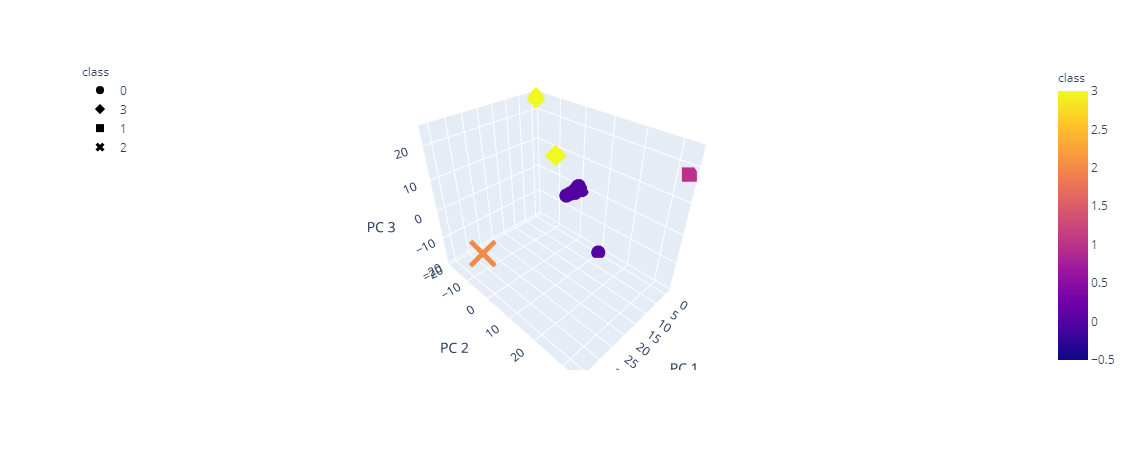

In [133]:
# Create a 3D-Scatter with the PCA data and the clusters
fig = px.scatter_3d(
    clustered_df,
    x="PC 1",
    y="PC 2",
    z="PC 3",
    color="class",
    symbol="class",
    width=800,
)
fig.update_layout(legend=dict(x=0, y=1))
fig.show()

#### Table of Tradable Cryptocurrencies

In [134]:
# Table with tradable cryptos
trade_crypto = (len(clustered_df))

In [135]:
# Print the total number of tradable cryptocurrencies
print(f'The total number of tradable cryptocurrencies is {trade_crypto}')

The total number of tradable cryptocurrencies is 533


#### Scatter Plot with Tradable Cryptocurrencies

In [165]:
# Scale data to create the scatter plot


In [164]:
# Plot the scatter with x="TotalCoinsMined" and y="TotalCoinSupply"
clustered_df.hvplot.scatter(
    x="TotalCoinsMined",
    y="TotalCoinSupply",
    hover_cols=["class"],
    by="class"
)

:NdOverlay   [class]
   :Scatter   [TotalCoinsMined]   (TotalCoinSupply,class)